# Instrument Response Functions, `DiscreteLogLikelihood` and `IRF_LogLikelihood`

The instrument response functions of a ground-based gamma ray telescope play a pivotal role in how we interpret the performance of the telescope. In particular, the energy dispersion and point spread function contain how well the telescope is able to reconstruct the energy and sky position of a given gamma ray. Formally,

\begin{align}
    \frac{d^2N(E, \Omega)}{dE d\Omega} = \int_{E_t} dE_t \iint_{\Omega_t} d\Omega_t R(E, \Omega|E_t, \Omega_t) \cdot \Phi(E_t, \Omega_t) \nonumber
\end{align}

where $R$ represents the instrument response functions,

\begin{align}
R(E, \Omega|E_t, \Omega_t) = \rm{exposure}(E_t, \Omega_t) \cdot \rm{PSF}(\Omega|E_t, \Omega_t)\cdot \rm{E}_{\rm{disp}}(E|E_t, \Omega_t) \nonumber
\end{align}


Where 
- $E_t$ and $\Omega_t$ represent the 'true' values of a given gamma ray event (what one would see with infinite precision),
- $E$ and $\Omega$ are the reconstructed or measured values which are representations for what a telescope actually measures/reconstructs,
- $\Phi$ is the astrophysical flux (units $\text{TeV}^{-1} \, \text{cm}^{-2} \, \text{s}^{-1}\, \text{deg}^{-2}$) we previously discussed is converted to an observational flux by application of the exposure which is a product of the observation time and effective area (units $\text{TeV}^{-1} \,\text{deg}^{-2}$),
- $d^2N(E, \Omega)/dEd\Omega$ is the observational flux of events by the given instrument i.e. the flux of measured event values,
- $\rm{PSF}$ is the _point spread function_ for the telescope and,
- $\rm{E}_{\rm{disp}}$ is the _energy dispersion_ for the telescope.


Before we move any further it would be useful to have some functions on hand to discuss specifics, so we will no discuss how to instantiate the `IRF_Loglikelihood` class.

## `IRF_LogLikelihood`

We'll jump straight into an example and leave the API at the end of the tutorial. 

Unlike the exposure tutorial we now have two sets of parameters for the energy and sky positions of gamma ray events; the true values (subscript t) and the measured values (no subscript). We are binning both sets so we need to instantiate binning geometries for each set.

We'll say that we're interested in energy values from 0.1 TeV to 100 TeV with 20 bins per decade for the true energy values and 10 bins per decade for the measured.
We'll choose our angular values to be between -3 and 3 degrees with an angular resolition of 0.02 degrees for the true values and 0.3 degrees for the measured.

You'll notice that we set the resolution of the true values higher than the measured, this is because the true values are independent of the telescope and theoretically should have infinite precision, while the measured values are artificially binned in part due to the finite resolution of the telescope. This difference in resolutions is to reflect that the true values should never ever have a lower resolution than the measured values. This is not enforced in `GammaBayes` but please don't do it as some functionality may break.

In [1]:
import numpy as np
from astropy import units as u
from gammabayes import GammaBinning


true_binning_geometry = GammaBinning(energy_axis=np.logspace(-1,2, 151)*u.TeV, 
                                        lon_axis=np.linspace(-3, 3, 151)*u.deg, 
                                        lat_axis=np.linspace(-3, 3, 151)*u.deg)
meas_binning_geometry = GammaBinning(energy_axis=np.logspace(-1,2, 121)*u.TeV, 
                                        lon_axis=np.linspace(-3, 3, 81)*u.deg, 
                                        lat_axis=np.linspace(-3, 3, 81)*u.deg)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For simplicitly we will focus on a single observationat the Galactic Centre for 5 observation hours.

In [2]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
pointing_dir = np.array([0,0])*u.deg
observation_time = 525*u.hr

We then pass this into `IRF_LogLikelihood` and it will handle the rest. 

In [3]:
irf_loglike = IRF_LogLikelihood(axes=meas_binning_geometry.axes, 
                            dependent_axes=meas_binning_geometry.axes, 
                            pointing_dir=pointing_dir, 
                            observation_time=observation_time)

Now let's see an overview of the IRFs contained.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


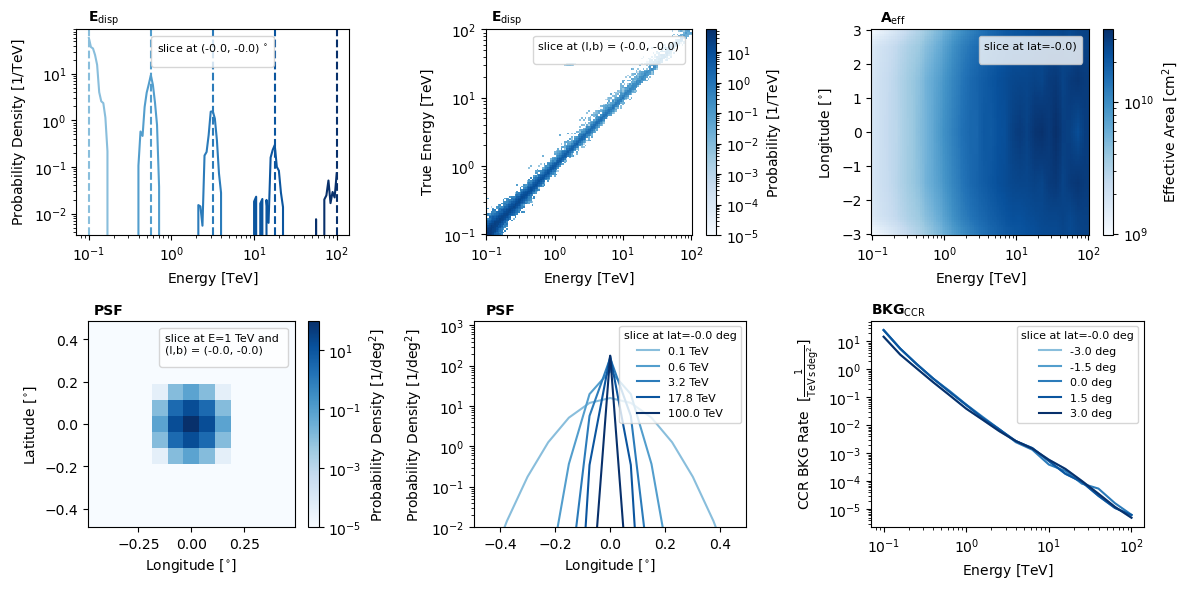

In [4]:
from matplotlib import pyplot as plt


irf_loglike.peek(figsize=(12,6))
plt.show()

### Point Spread Function

From a probability perspective the point spread function is the probability density function of measuring a given sky position $\Omega$ given the set of true values $E_t$ and $\Omega_t$.

Formally if one integrates over solid angle then, 

\begin{equation}
    1 = \iint_{\Omega} PSF(\Omega|E_t, \Omega_t) .
\end{equation}

Let's look at a representation of this function.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


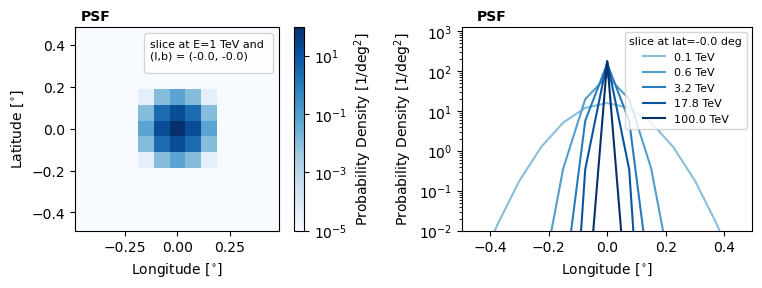

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

irf_loglike._plot_psf_pdf(ax=axs[0])
irf_loglike._plot_psf_lines(ax=axs[1], plot_kwargs={'colormap':'Blues', 'norm':'log'})

plt.tight_layout()
plt.show()

This shows a slice of probability density function when galactic latitude equals 0 deg for various true energy values and true sky position of (0,0). 

You can see that the probability density is maximal at (0,0) meaning that the telescope has the highest probability of reconstructing the same value.

If this were not the case it would not make sense, say if it was maximal at (1,1) that means when a gamma ray comes from (0,0) the telescope is most likely going to say that it came (1,1), this is no bueno.

Another behaviour is that as the energy decreases the point spread function broadens, meaning that it can't as precisely say what the sky position of an incoming gamma ray was. The reason for this by the way is that lower energy gamma rays produce a wider shower making it harder to reconstruct the originating sky position.

You can access the log of the point spread function through the `log_psf` method on the `IRF_Likelihood` class and the relevant unit through the `psf_units` attribute.

In [6]:
irf_loglike.log_psf(recon_lon=0*u.deg, recon_lat=0*u.deg, 
                    true_energy=1*u.TeV, true_lon=0*u.deg, true_lat=0*u.deg), irf_loglike.psf_units

(array([4.63845646]), Unit("1 / deg2"))

__A big thing to note__ is that this value is not the log of normalised PSF value, i.e. it doesn't directly correspond to a probability density. However, the shape of this function is correct, so we can integrate these values of longitude and latitude to normalise. This is done in `GammaBayes` to keep individual computation times down with the log of the normalisation cached in an array which can then be applied for a given set of true values.

### Energy Dispersion

The second IRF is called the _Energy Dispersion_ and similar to how the point spread function quantifies how well a telescope can reconstruct the sky position of a given gamma ray, the energy dispersion quantifies how well it can reconstruct the energy values.

Formally, 

\begin{align}

1 = \int_E \text{E}_\text{disp}(E|E_t, \Omega_t)

\end{align}

Having a look at some of the outputs of this function for CTAO we see,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


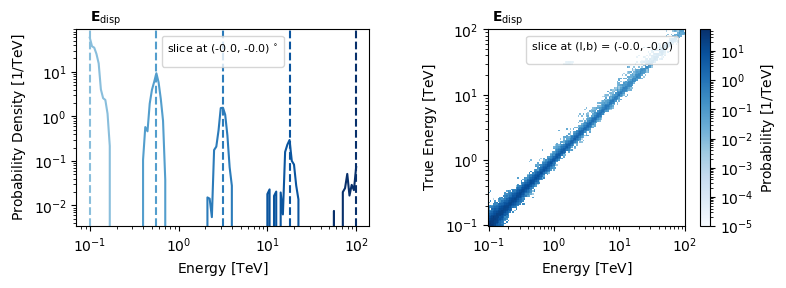

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

irf_loglike._plot_edisp_pdf(ax=axs[0], plot_kwargs={'colormap':'Blues', 'norm':'log'})
irf_loglike._plot_edisp_density(ax=axs[1], pcolormesh_kwargs={'cmap':'Blues', 'norm':'log'})

plt.tight_layout()
plt.show()

The plot on the left shows the energy dispersion for various true energy values with the y-axis being the probability density, the right figure essentially the same thing but the true energy values are represented on the y-axis with the probability represented by the colour.

One can see that the energy dispersion peaks around the true energy values saying that if a gamma ray of 1 TeV for example hit the atmosphere, the CTA is most likely to reconstruct an energy for it around 1 TeV.

You can access the unnormalised log energy dispersion values through the `log_edisp` method and the relevant units under the `edisp_units` attribute.

In [8]:
irf_loglike.log_edisp(recon_energy=1*u.TeV, true_energy=1*u.TeV, true_lon=0*u.deg, true_lat=0*u.deg), irf_loglike.edisp_units

(-2.8620978757269575, Unit("1 / TeV"))

### Effective Area

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Longitude [$\\mathrm{{}^{\\circ}}$]'>

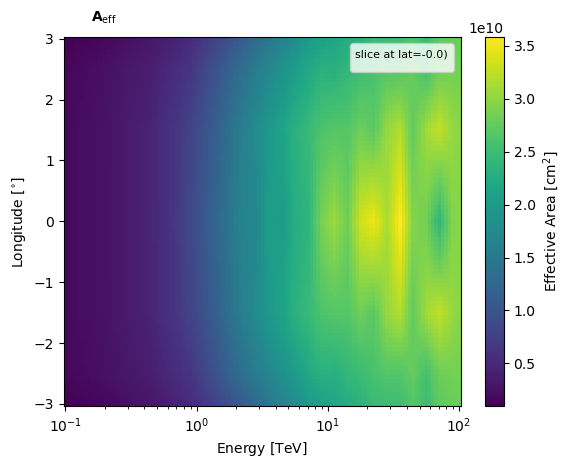

In [9]:
irf_loglike._plot_aeff(ax=None)

The effective area as in the name is how large the effective collection area of a given telescope is. This is not only a function of the cross section of the telescope from the perspective of the gamma ray but also the efficiency of the telescope. 

Say for CTAO, events with large offets from the pointing direction of the telescope have a larger distance to travel through the atmosphere than one that came directly from the pointing direction. This means that the likelihood of CTAO to see this event are smaller because it has more time to be absorbed in the atmosphere and the Cherenkov radiation will be dimmer. 

This dependence is smaller than that of the energy. As the energy increases the effective area increases dramatically, due to the efficiency of higher energy events being higher. This comes the fact that with more energy, more energy came be expelled as Cherenkov radiation so the events are brighter, and due to the higher energy the particles are travelling faster within the atmosphere so that propagate further as well.

You can access the direct log effective area values through the `log_aeff` method and the relevant units under the `aeff_units` attribute.

In [10]:
irf_loglike.log_aeff(energy=1*u.TeV, lon=0*u.deg, lat=0*u.deg), irf_loglike.aeff_units

(22.968884205143716, Unit("cm2"))

### As an observational likelihood

The main purpose for the IRFs when performing inference with `GammaBayes` are as the observational likelihood to calculate the marginalised probability values formally shown below.


\begin{equation}

\newcommand{\Idepend}{\mathbf{obs}}
\newcommand{\Mdepend}{\mathcal{M}_i, \vec{\phi}_i, \mathcal{M}_\alpha}
\newcommand{\kdatum}{\{E, \vec{\Omega}\}_k}
\newcommand{\kdatumtrue}{\{E^t, \vec{\Omega^t}\}_k}
\newcommand{\parameters}{\{\vec{\theta_i}\}_i, \vec{\alpha}}


\newcommand{\likelihood}{\mathcal{L}(\kdatum | \kdatumtrue, \Idepend)}

\newcommand{\prior}{\pi(\kdatumtrue |\mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \text{exposure})}

\newcommand{\evidence}{\mathcal{Z}(\kdatum | \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \Idepend)}

\newcommand{\posterior}{p(\kdatumtrue |\kdatum, \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \Idepend)}

\evidence = \int_{E^t} dE^t \int_{\Omega^t} d\Omega^t \; \likelihood \prior

\end{equation}


where at least typically,


\begin{equation}

\newcommand{\Idepend}{\mathbf{obs}}
\newcommand{\Mdepend}{\mathcal{M}_i, \vec{\phi}_i, \mathcal{M}_\alpha}
\newcommand{\kdatum}{\{E, \vec{\Omega}\}_k}
\newcommand{\kdatumtrue}{\{E^t, \vec{\Omega^t}\}_k}
\newcommand{\parameters}{\{\vec{\theta_i}\}_i, \vec{\alpha}}


\newcommand{\likelihood}{\mathcal{L}(\kdatum | \kdatumtrue, \Idepend)}



\likelihood = \text{PSF}(\Omega|E^t, \Omega^t) \times \text{E}_{\text{disp}}(E|E^t, \Omega^t)

\end{equation}

with no changes needed for the normalisation as

\begin{align}

\newcommand{\Idepend}{\mathbf{obs}}
\newcommand{\Mdepend}{\mathcal{M}_i, \vec{\phi}_i, \mathcal{M}_\alpha}
\newcommand{\kdatum}{\{E, \vec{\Omega}\}_k}
\newcommand{\kdatumtrue}{\{E^t, \vec{\Omega^t}\}_k}
\newcommand{\parameters}{\{\vec{\theta_i}\}_i, \vec{\alpha}}


\newcommand{\likelihood}{\mathcal{L}(\kdatum | \kdatumtrue, \Idepend)}



1 = \int_E dE \iint_\Omega d\Omega \; \likelihood &=\int_E dE \iint_\Omega d\Omega  \;\text{PSF}(\Omega|E^t, \Omega^t) \times \text{E}_{\text{disp}}(E|E^t, \Omega^t) \nonumber \\
&= \int_E dE \; \text{E}_{\text{disp}}(E|E^t, \Omega^t) \iint_\Omega d\Omega  \;\text{PSF}(\Omega|E^t, \Omega^t)  \nonumber \\
&= 1\times1 = 1  \nonumber \\

\end{align}

For this reason, it would be handy to just have a method that outputs the combined (log) probability density value... which `IRF_LogLikelihood` has as the default `__call__` method or from the `logfunction` methods.

In [11]:
manual_log_product = irf_loglike.log_edisp(1*u.TeV, 1*u.TeV, 0*u.deg, 0*u.deg)+irf_loglike.log_psf(0*u.deg, 0*u.deg, 1*u.TeV, 0*u.deg, 0*u.deg)

call_method = irf_loglike(recon_energy=1*u.TeV, recon_lon=0*u.deg, recon_lat=0*u.deg, true_energy=1*u.TeV, true_lon=0*u.deg, true_lat=0*u.deg)

single_likelihood_method = irf_loglike.logfunction(recon_energy=1*u.TeV, recon_lon=0*u.deg, recon_lat=0*u.deg, true_energy=1*u.TeV, true_lon=0*u.deg, true_lat=0*u.deg)


manual_log_product, call_method, single_likelihood_method

(array([1.77635858]), array(1.77635858), array(1.77635858))

Next we will discuss how we store events in `GammaBayes`.